# Online Behavior ML model

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load the dataset

In [2]:
file_path = '/Users/derrickmarkbavaudbaruga/Documents/fall 2024/Extra Xtra/talkn bout practice/magsafe/ml models/3 Online Behavior/online_shoppers_intention.csv'
df = pd.read_csv(file_path)

### Display the first few rows of the dataframe

In [3]:
print("Initial Data Preview:")
print(df.head())

Initial Data Preview:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.

### Summary Statistics

In [4]:
summary = df.describe(include = 'all')
print(summary)

        Administrative  Administrative_Duration  Informational  \
count     12330.000000             12330.000000   12330.000000   
unique             NaN                      NaN            NaN   
top                NaN                      NaN            NaN   
freq               NaN                      NaN            NaN   
mean          2.315166                80.818611       0.503569   
std           3.321784               176.779107       1.270156   
min           0.000000                 0.000000       0.000000   
25%           0.000000                 0.000000       0.000000   
50%           1.000000                 7.500000       0.000000   
75%           4.000000                93.256250       0.000000   
max          27.000000              3398.750000      24.000000   

        Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             12330.000000    12330.000000             12330.000000   
unique                     NaN             NaN           

## Visualisation

### Barplot of the Quantity Ordered by Product Category

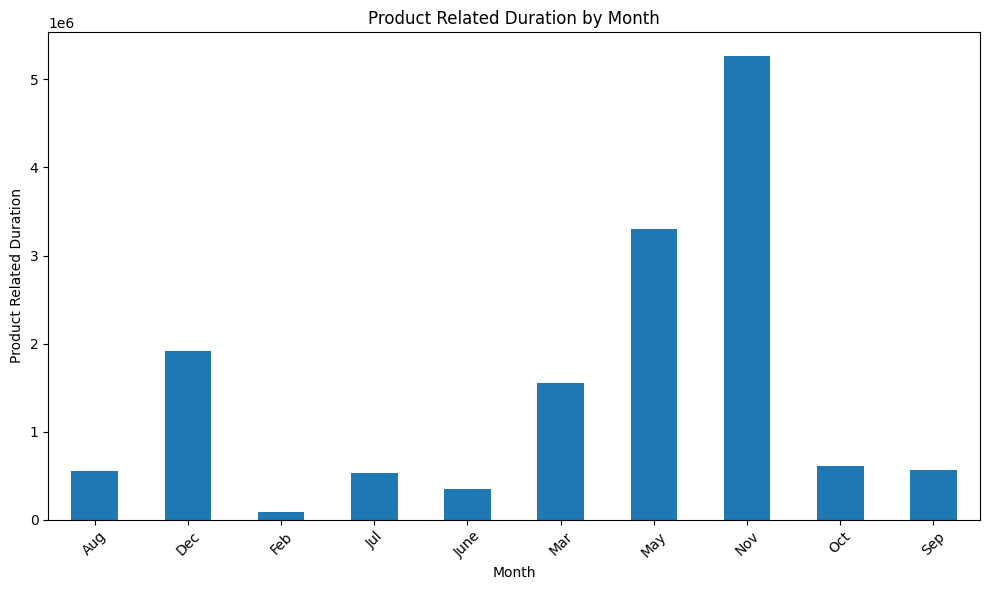

In [5]:
%matplotlib inline

plt.figure(figsize=(10, 6))
df.groupby('Month')['ProductRelated_Duration'].sum().plot(kind='bar')
plt.title('Product Related Duration by Month')
plt.xlabel('Month')
plt.ylabel('Product Related Duration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Line graph of sales per month

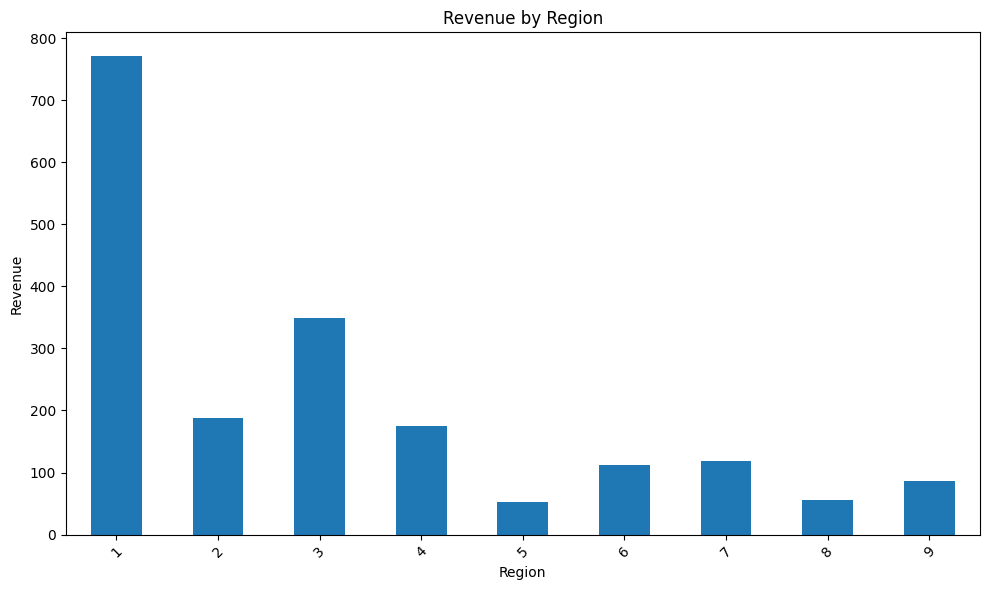

In [6]:
plt.figure(figsize=(10, 6))
df.groupby('Region')['Revenue'].sum().plot(kind='bar')
plt.title('Revenue by Region')
plt.xlabel('Region')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bar graph of the sales by city

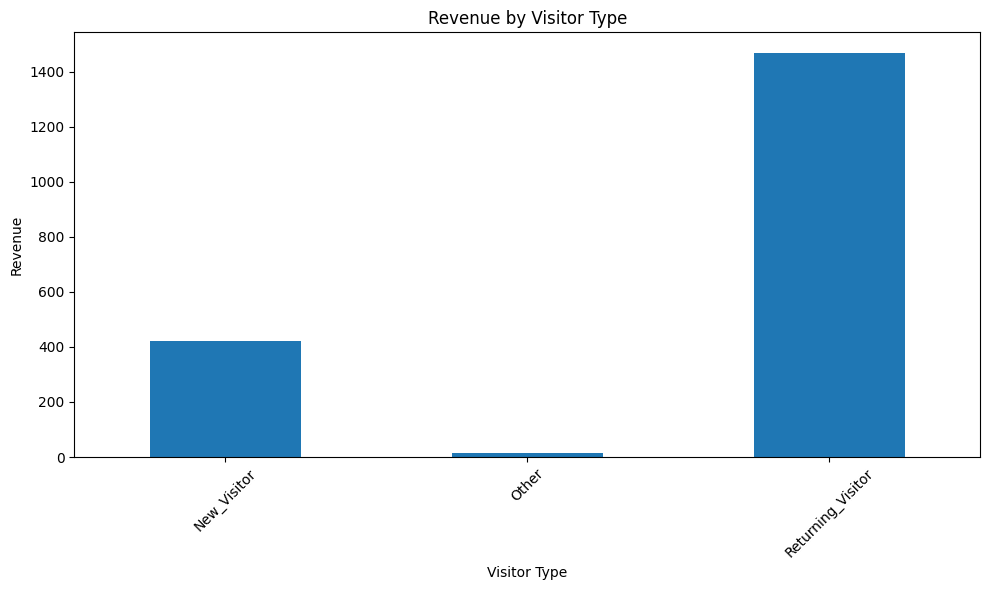

In [7]:
%matplotlib inline

plt.figure(figsize=(10, 6))
df.groupby('VisitorType')['Revenue'].sum().plot(kind='bar')
plt.title('Revenue by Visitor Type')
plt.xlabel('Visitor Type')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bar graph of sales by time of day

## Data Cleaning

In [8]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [9]:
# Drop unnecessary columns
df.drop(['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'PageValues', 'SpecialDay', 'Month', 'VisitorType'], axis=1, inplace=True)

In [10]:
categorical_columns = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'Revenue']

# Convert categorical columns to dummy variables
df_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

## Feature Engineering

### Separate features and target

In [11]:
# Separate features and target
X = df.drop('Revenue', axis=1).values
y = df['Revenue'].values

### Split the data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize the features

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Convert to PyTorch tensors

In [14]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Create DataLoader instances for training and testing

In [15]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SalesPredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(SalesPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Initialize the model

In [16]:
input_dim = X_train.shape[1]
model = SalesPredictionModel(input_dim)

### Define loss function and optimizer

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_X.size(0)
        
        epoch_loss = total_loss / len(train_loader.dataset)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_X.size(0)
    
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

### Train the model

In [18]:
train_model(model, criterion, optimizer, train_loader, num_epochs=100)

Epoch [10/100], Loss: 0.1197
Epoch [20/100], Loss: 0.1162
Epoch [30/100], Loss: 0.1141
Epoch [40/100], Loss: 0.1118
Epoch [50/100], Loss: 0.1084
Epoch [60/100], Loss: 0.1062
Epoch [70/100], Loss: 0.1049
Epoch [80/100], Loss: 0.1025
Epoch [90/100], Loss: 0.0989
Epoch [100/100], Loss: 0.0971


### Evaluate the model

In [19]:
test_loss = evaluate_model(model, criterion, test_loader)
print(f'Mean Squared Error on Test Set: {test_loss:.4f}')

Mean Squared Error on Test Set: 0.1376
